In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from fastai.text import *

### Raw Data

In [0]:
BASE_PATH = Path('drive/My Drive/Google Colab/DL-project')
DATA_PATH = BASE_PATH/"dataset/output/"

In [4]:
df = pd.read_csv(DATA_PATH/"emotions_df.csv")
df = df[df.columns.difference(['Unnamed: 0','id'])]
df

,emotion,intensity,is_valid,text
0,anger,0.938,False,How the fu*k! Who the heck! moved my fridge!.....
1,anger,0.896,True,So my Indian Uber driver just called someone t...
2,anger,0.896,False,@DPD_UK I asked for my parcel to be delivered ...
3,anger,0.896,False,so ef whichever butt wipe pulled the fire alar...
4,anger,0.896,False,Don't join @BTCare they put the phone down on ...
...,...,...,...,...
3955,sadness,0.833,False,Common app just randomly logged me out as I wa...
3956,sadness,0.688,False,"I'd rather laugh with the rarest genius, in be..."
3957,sadness,0.458,False,If you #invest in my new #film I will stop ask...
3958,sadness,0.333,False,"Just watched Django Unchained, Other people ma..."


### Load and preprocess the data and form a databunch

In [5]:
data_lm = (TextList.from_df(df, DATA_PATH, cols=["text"])
                  .random_split_by_pct(0.1)
                  .label_for_lm()
                  .databunch(bs=48))

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:215: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [6]:
data_lm.show_batch()

idx,text
0,"alarm in xxunk bc i was sound asleep # pissed # angry # upset # tired # sad # tired # hangry xxrep 6 # xxbos xxmaj do n't join xxunk they put the phone down on you , talk over you and are rude . xxmaj taking money out of my acc xxunk ! # fuming xxbos xxmaj when you 've still got a whole season of xxmaj xxunk"
1,a half xxunk excuse and now here i am burning in hell forever xxbos @manutd you have had from me over the years is irrelevant . xxmaj its an absolute joke . # xxunk # xxunk # fuming # xxunk # joke # xxunk xxbos xxunk _ _ xxmaj part xxunk xxunk for a xxunk xxunk or two - this was xxup not what i expected . xxup sort xxup
2,"yeah i received a fine today which i am furious about , currently xxunk it after being a xxunk for so long ... xxbos xxmaj men in rage xxunk those that wish them best . # rage # emotions # negative # positive # wish # xxunk # xxunk # xxunk # control # believe # best # hope xxbos xxmaj in 2016 , xxmaj black people are xxup still"
3,of which things i should be outraged at + in which order ? # outrage # racism # xxunk # abortion # cops xxbos xxunk xxunk xxunk true . xxmaj just me xxunk xxunk because i 'm still bitter with xxmaj xxunk . xxmaj like an old man yelling from his xxunk . xxbos i will never watch xxunk anatomy xxwrep 5 ever again if xxmaj xxunk xxmaj xxunk takes
4,"# xxunk xxbos xxmaj dear xxmaj xxunk .. xxmaj it is hard to xxunk this but for once try to xxunk this bitter xxunk ... that is .. xxmaj pakistan is number one in xxmaj test xxunk ! ! ! xxbos a little nose irritation and a little more xxunk on my body . i 'm so not into flu , into flu , into flu # xxunk xxbos i"


In [7]:
data_lm.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '#',
 '.',
 'the',
 'i',
 ',',
 'to',
 'a',
 'and',
 '!',
 'of',
 'is']

In [8]:
data_lm.train_ds[0][0]

Text xxbos xxmaj how the xxunk ! xxmaj who the xxunk ! moved my xxunk ! ... should i xxunk the xxunk door . # angry # mad # #

In [9]:
data_lm.train_ds[0][0].data[:10]

array([ 2,  5, 72, 11,  0, 17,  5, 78, 11,  0])

In [10]:
len(data_lm.vocab.itos),len(data_lm.train_ds)

(2512, 3564)

In [0]:
# Save the databunch
data_lm.save()

In [0]:
## Load already saved databunch
# data_lm = load_data(DATA_PATH, 'lm_databunch', bs=bs)

### The Transfer Learning Step
The AWD_LSTM object contains the pretrained weights and the neural net architecture of the wikitext-103 language model.

In [0]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [13]:
# Training (fine-tuning) the Twitter Data language model
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


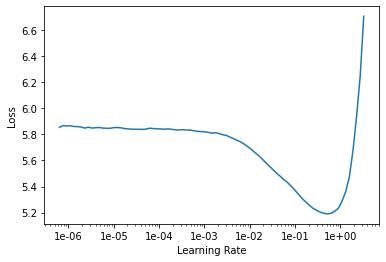

In [14]:
learn_lm.recorder.plot()

In [50]:
learn_lm.fit_one_cycle(1, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.655357,4.039533,0.250794,00:04


In [0]:
# Save the weights
learn_lm.save('fit_1')

In [52]:
learn_lm.load('fit_1')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (3564 items)
x: LMTextList
xxbos xxmaj how the xxunk ! xxmaj who the xxunk ! moved my xxunk ! ... should i xxunk the xxunk door . # angry # mad # #,xxbos xxmaj so my xxmaj indian xxmaj uber driver just called someone the n word . xxmaj if i was n't in a moving xxunk i 'd have jumped out # disgusted,xxbos so xxunk whichever butt wipe pulled the fire alarm in xxunk bc i was sound asleep # pissed # angry # upset # tired # sad # tired # hangry xxrep 6 #,xxbos xxmaj do n't join xxunk they put the phone down on you , talk over you and are rude . xxmaj taking money out of my acc xxunk ! # fuming,xxbos xxmaj when you 've still got a whole season of xxmaj xxunk to watch and a stupid cunt in work ruins it for us 😭 😭 xxunk # raging # xxunk
y: LMLabelList
,,,,
Path: drive/My Drive/Google Colab/DL-project/dataset/output;

Valid: LabelList (396 items)
x: LMTextList
xxbos xxunk take me with you ! ! xxup jk . xxmaj have fun , relax , get a xxunk 

In [0]:
learn_lm.unfreeze()

In [54]:
learn_lm.fit_one_cycle(7, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.867778,3.920544,0.265278,00:04
1,3.755624,3.808944,0.277183,00:04
2,3.590013,3.734940,0.284722,00:05
3,3.406483,3.690333,0.290675,00:05
4,3.205107,3.673542,0.295139,00:05
5,3.021436,3.679144,0.300794,00:05
6,2.887572,3.679475,0.301389,00:05


In [0]:
learn_lm.save("fine_tuned")

In [0]:
learn_lm.save_encoder('fine_tuned_enc')

#### Generate twitter like text, with the fine-tuned Twitter language model


In [0]:
TEXT = "#not #happy because"
N_WORDS = 40
N_SENTENCES = 2

In [63]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

#not #happy because you 're # happy and you have a # happy . You 'll not always see someone who loves me # smile xxbos 
 
  What a # joy # happy # happy xxbos Stay the day i
#not #happy because it 's just a # smile . We 're # happy and not # friends . # fashion # friends # love # twitter # success xxbos When new 's are r soft and horrific i 'm going


### Building an Tweet Emotion Classifier

In [65]:
data_clas = (TextList.from_df(df=df, path=DATA_PATH, cols='text', vocab=data_lm.vocab)
             .split_from_df(col='is_valid')
             .label_from_df(cols=['emotion'])
             .databunch(bs=48))

In [0]:
data_clas.save('twitter_textlist_class')

In [66]:
data_clas.show_batch()

text,target
xxbos [ xxmaj moment of levity on the xxup xxunk ] xxmaj baby : i want xxup isis ! xxmaj give me xxup isis ! \n xxmaj mom : xxmaj xxunk ! \n xxmaj baby : i want xxup isis ! \n xxmaj west xxmaj indian woman : xxmaj she wants what ? \n xxmaj mom : * xxmaj xxunk * .,joy
"xxbos xxunk xxmaj start w / the 3 xxunk in xxmaj blue xxmaj xxunk \n 1 ) xxmaj wild \n xxunk \n xxunk xxmaj me down 😭 😭 for # xxmaj xxunk \n xxmaj also , \n xxunk xxmaj good . # serious xxunk / xxunk xxunk",sadness
xxbos xxmaj folk xxmaj band ' xxmaj xxunk xxmaj down ' will be replaced by ' xxmaj the xxmaj paul xxmaj xxunk xxmaj xxunk ' at xxmaj xxunk xxmaj bank xxmaj park xxmaj sat 24 11 am - 3 pm due to ill health # jazz,sadness
xxbos xxmaj he : u r beautiful \n xxmaj she : i xxunk a bf \n \n xxmaj same as \n \n # xxmaj india : u guys r # terrorist \n # xxmaj pak : we have # xxunk # xxunk . \n \n # xxunk # terror,fear
"xxbos xxmaj xxunk a \n xxunk heart , \n so far & & \n yet so near , \n the years so \n tough & & xxunk , \n this xxunk \n road , \n still xxunk ! # depression \n \n # xxunk # xxunk",sadness


In [0]:
from sklearn.metrics import f1_score

@np_func
def f1(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1), average=None)

In [0]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3, metrics=[accuracy,f1])
learn_c.load_encoder('fine_tuned_enc')
learn_c.freeze()

In [74]:
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


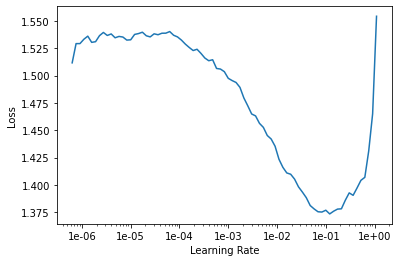

In [75]:
learn_c.recorder.plot()

In [0]:
lr = 3e-2

In [76]:
learn_c.fit_one_cycle(2, 3e-2, moms=(0.8,0.7))

In [77]:
learn_c.fit_one_cycle(2, 3e-2, moms=(0.8,0.7))

In [78]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(1, slice(3e-2/(2.6**4),3e-2), moms=(0.8,0.7))

In [79]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(1, slice(3e-2/2/(2.6**4),3e-2/2), moms=(0.8,0.7))

In [0]:
learn_c.save('3rd')

In [82]:
learn_c.unfreeze()
learn_c.fit_one_cycle(2, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

In [0]:
learn_c.save('clas')

### Backward Training

In [88]:
data_clas_bwd = (TextList.from_df(df=df, path=DATA_PATH, cols='text', vocab=data_lm.vocab)
             .split_from_df(col='is_valid')
             .label_from_df(cols=['emotion'])
             .databunch(bs=48, backwards=True))

In [0]:
data_clas_bwd.save('twitter_textlist_class_bwd')

In [89]:
data_clas_bwd.show_batch()

text,target
. * xxunk xxmaj * : mom xxmaj \n ? what wants she xxmaj : woman indian xxmaj west xxmaj \n ! isis xxup want i : baby xxmaj \n ! xxunk xxmaj : mom xxmaj \n ! isis xxup me give xxmaj ! isis xxup want i : baby xxmaj ] xxunk xxup the on levity of moment xxmaj [ xxbos,joy
. elated were all .. xxunk xxmaj @ 's xxunk xxup xxunk xxmaj the to listen anyone xxmaj ? work not did it if xxunk a for xxunk 's mom xxmaj & & xxunk xxunk xxmaj would why xxmaj xxunk xxup $ xxbos,joy
". 4 xxrep everybody pleasing about n't is life xxmaj . xxunk a is happiness xxmaj . be them let then , it like n't do others if xxmaj . be to want you who be xxmaj . happy be xxmaj xxbos",joy
"camps terror # xxunk to xxunk time xxmaj ? pakistan xxmaj # on xxunk xxmaj # for xxunk what xxmaj . there been not russia xxmaj # had us xxunk almost us xxup # , war xxunk xxmaj # in xxmaj xxbos",fear
"xxunk # ! wtf xxup ! me kidding you are ... xxunk xxmaj xxunk xxmaj and , black xxmaj jack xxmaj , rock xxmaj the xxmaj / w . 4 xxrep 2 xxunk xxmaj # . 5 xxrep really xxmaj xxbos",fear


In [0]:
learn_c_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, drop_mult=0.3, metrics=[accuracy,f1])
learn_c_bwd.load_encoder('fine_tuned_enc')
learn_c_bwd.freeze()

In [94]:
learn_c_bwd.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


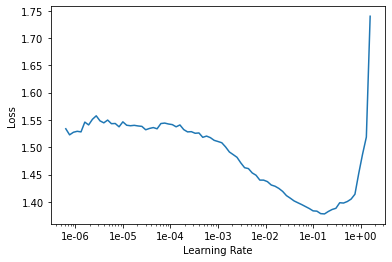

In [95]:
learn_c_bwd.recorder.plot()

In [0]:
lr = 3e-2

In [97]:
learn_c_bwd.fit_one_cycle(4, 3e-2, moms=(0.8,0.7))

In [99]:
learn_c_bwd.freeze_to(-2)
learn_c_bwd.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

In [100]:
learn_c_bwd.freeze_to(-3)
learn_c_bwd.fit_one_cycle(1, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

In [0]:
learn_c_bwd.save('3rd_bwd')

In [102]:
learn_c_bwd.unfreeze()
learn_c_bwd.fit_one_cycle(2, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

In [0]:
learn_c_bwd.save('clas_bwd')

### Ensemble - bidirectional model

In [0]:
data_clas = load_data(DATA_PATH, 'twitter_textlist_class', bs=48, num_workers=1)
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,f1])
learn_c.load('clas', purge=False);

In [87]:
preds,targs = learn_c.get_preds(ordered=True)
accuracy(preds,targs),f1(preds,targs)

(tensor(0.7914), tensor([0.7872, 0.8198, 0.8436, 0.6997], dtype=torch.float64))

In [0]:
data_clas_bwd = load_data(DATA_PATH, 'twitter_textlist_class_bwd', bs=48, num_workers=1, backwards=True)
learn_c_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,f1])
learn_c_bwd.load('clas_bwd', purge=False);

In [105]:
preds_b,targs_b = learn_c_bwd.get_preds(ordered=True)
accuracy(preds_b,targs_b),f1(preds_b,targs_b)

(tensor(0.7927), tensor([0.8021, 0.8038, 0.8507, 0.6997], dtype=torch.float64))

In [0]:
preds_avg = (preds+preds_b)/2

In [107]:
accuracy(preds_avg,targs_b),f1(preds_avg,targs_b)

(tensor(0.8180), tensor([0.8241, 0.8356, 0.8676, 0.7295], dtype=torch.float64))

### Predictions

In [0]:
def predict_emotion(text):
  data_clas = load_data(DATA_PATH, 'twitter_textlist_class', bs=48, num_workers=1)
  learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,f1])
  learn_c.load('clas', purge=False);

  data_clas_bwd = load_data(DATA_PATH, 'twitter_textlist_class_bwd', bs=48, num_workers=1, backwards=True)
  learn_c_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,f1])
  learn_c_bwd.load('clas_bwd', purge=False)

  pred = learn_c.predict(text)
  pred_b = learn_c_bwd.predict(text)

  return pred, pred_b

In [122]:
predict_emotion('#raging')
# learn_c.predict("#raging")

((Category anger,
  tensor(0),
  tensor([9.9995e-01, 2.3923e-05, 1.9431e-05, 4.0864e-06])),
 (Category anger,
  tensor(0),
  tensor([1.0000e+00, 3.0629e-07, 7.9551e-07, 9.1390e-08])))

In [123]:
predict_emotion("#happy")

((Category joy,
  tensor(2),
  tensor([1.0451e-03, 4.2923e-05, 9.9811e-01, 8.0074e-04])),
 (Category joy,
  tensor(2),
  tensor([3.4354e-05, 4.4864e-06, 9.9956e-01, 3.9658e-04])))

In [124]:
predict_emotion("I wish I could end my life!")

((Category fear, tensor(1), tensor([0.0786, 0.5774, 0.0554, 0.2887])),
 (Category sadness, tensor(3), tensor([0.1602, 0.2600, 0.0524, 0.5274])))

In [125]:
predict_emotion("After watching DDLJ I kept on crying")

((Category sadness, tensor(3), tensor([0.0352, 0.0526, 0.0465, 0.8658])),
 (Category sadness, tensor(3), tensor([0.0192, 0.0060, 0.4572, 0.5176])))

In [126]:
predict_emotion("fuck you")

((Category anger, tensor(0), tensor([0.9364, 0.0315, 0.0160, 0.0161])),
 (Category anger, tensor(0), tensor([0.5795, 0.3987, 0.0014, 0.0203])))

In [127]:
predict_emotion("This isn't fair and you'll pay for this...")

((Category joy, tensor(2), tensor([0.2150, 0.1651, 0.3424, 0.2775])),
 (Category fear, tensor(1), tensor([0.0234, 0.7808, 0.0885, 0.1073])))

In [128]:
predict_emotion("How I wish I was with you")

((Category fear, tensor(1), tensor([0.2209, 0.3975, 0.1245, 0.2571])),
 (Category sadness, tensor(3), tensor([0.0232, 0.2044, 0.1866, 0.5859])))

In [129]:
predict_emotion("Hurray! I am so happy for you!")

((Category joy, tensor(2), tensor([0.0029, 0.0019, 0.9819, 0.0132])),
 (Category joy, tensor(2), tensor([0.0019, 0.0019, 0.9888, 0.0074])))

In [130]:
predict_emotion("I knew you were going to achieve this #happy")

((Category joy, tensor(2), tensor([0.0210, 0.0607, 0.9115, 0.0068])),
 (Category joy,
  tensor(2),
  tensor([7.8778e-04, 2.2121e-03, 9.9352e-01, 3.4780e-03])))

### Anger - Regression

In [0]:
anger_df = pd.read_csv(DATA_PATH/"anger_df.csv")

In [171]:
data_anger_lm = (TextList.from_df(anger_df, DATA_PATH, cols=["text"])
                  .random_split_by_pct(0.1)
                  .label_for_lm()
                  .databunch(bs=48))

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:215: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [172]:
data_anger_lm.show_batch()

idx,text
0,"pissed # angry # upset # tired # sad # tired # hangry xxrep 6 # xxbos xxmaj do n't xxunk xxunk they put the phone down on you , talk over you and are rude . xxmaj taking money out of my xxunk xxunk ! # fuming xxbos xxmaj my blood is boiling xxbos xxmaj when you 've still got a whole season of xxmaj xxunk to watch and"
1,and what not so xxunk . # damn xxbos xxmaj making my xxunk cry ! ! xxmaj xxunk wait for revenge 🤗 xxunk 🏻 xxbos xxmaj xxunk ! xxmaj you do n't just tell a true xxunk xxunk to switch a xxunk ' team that juz xxunk your own team . xxmaj you juz do n't ! # insult xxbos i got a xxup no xxup response again from an
2,xxunk the xxmaj world in the xxunk of their tantrums . xxmaj you are one . xxbos xxunk ' you people ' infuriate me ! xxbos xxunk xxmaj xxunk is that the party did decide but the party has been xxunk xxunk into a xxunk hell - xxunk of white xxunk resentment xxbos xxmaj so # angry about my xxunk order . 6 # xxunk xxunk i xxunk an order
3,xxunk and xxunk off 😡 xxbos i 'm nothing but a xxunk and bitter xxunk xxbos xxunk something needs to be done about people xxunk machines - nobody can use 3 machines at one time ! # angry # xxunk # xxunk xxbos xxunk xxmaj xxunk people still got a grudge against him for no xxunk like wtf ? ! xxbos xxunk then he said talking about xxunk xxunk xxunk
4,"person ruins season xxunk for me , i will be so angry xxbos xxmaj what the fuck am i supposed to do with no xxunk , no dinner , no money and i 'm off to work # hangry # xxunk xxbos xxunk not only are your xxunk xxunk your e ticket xxunk is too xxunk to get on two xxunk and late for work # fuming # xxunk reply"


In [0]:
learn_anger_lm = language_model_learner(data_anger_lm, AWD_LSTM, drop_mult=0.3)

In [174]:
learn_anger_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


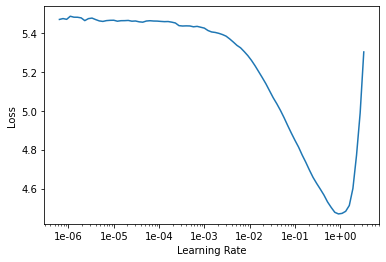

In [175]:
learn_anger_lm.recorder.plot()

In [0]:
lr = 1e-1

In [181]:
learn_anger_lm.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.952948,4.008181,0.211905,00:01


In [0]:
learn_anger_lm.unfreeze()

In [183]:
learn_anger_lm.fit_one_cycle(10, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.984542,3.670877,0.258929,00:01
1,3.967871,5.183818,0.225595,00:01
2,4.460701,4.745324,0.220536,00:01
3,4.467501,4.153651,0.244345,00:01
4,4.353413,3.980805,0.249702,00:01
5,4.214321,3.878614,0.266071,00:01
6,4.065575,3.817906,0.265476,00:01
7,3.910088,3.762522,0.277381,00:01
8,3.751027,3.724550,0.281548,00:01
9,3.601384,3.716215,0.286607,00:01


In [0]:
learn_anger_lm.save('fine_tuned_anger')

In [0]:
learn_anger_lm.save_encoder('fine_tuned_anger_enc')

In [186]:
anger_regr = (TextList.from_df(df=anger_df, path=DATA_PATH, cols='text', vocab=data_anger_lm.vocab)
             .split_from_df(col='is_valid')
             .label_from_df(cols=['intensity'], label_cls=FloatList)
             .databunch())

In [187]:
anger_regr.show_batch()

text,target
"xxbos i am # real # xxunk , i will not let # america down \n i have found us , now go and get us \n i let it out and i let it in \n i # rage i # lol \n xxunk",0.542
"xxbos xxup someone xxup let xxup xxunk xxup in xxup my xxup house , i xxup bet xxup it xxunk i xxup kill xxup that xxup xxunk xxup when i xxup get xxup my xxup hands xxup on xxup him # rage # xxunk",0.771
xxbos xxmaj now it 's time to remove xxup xxunk from the team xxunk . xxmaj xxunk it . xxmaj rip the xxmaj xxunk - xxmaj xxunk off . xxmaj it 'll sting for a bit but everyone will get over it .,0.521
xxbos i will never watch xxunk xxunk xxwrep 5 ever again if xxmaj xxunk xxmaj xxunk takes away another xxup xxunk character ☹ ️ ☹ ️ ☹ ️ ☹ ️ ☹ ️ ☹ ️ ☹ ️ ☹ ️ ☹ ️ ☹ ️,0.583
"xxbos xxup someone xxup let xxup xxunk xxup in xxup my xxup house , i xxup bet xxup it xxunk i xxup kill xxup that xxup xxunk xxup when i xxup get xxup my xxup hands xxup on xxup him # xxunk",0.764


In [0]:
learn_anger = text_classifier_learner(anger_regr, AWD_LSTM, drop_mult=0.3,metrics = rmse)
learn_anger.loss_func=MSELossFlat()
learn_anger.load_encoder('fine_tuned_anger_enc')
learn_anger.freeze()

In [189]:
learn_anger.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


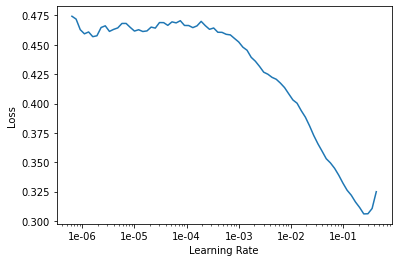

In [190]:
learn_anger.recorder.plot()

In [0]:
lr = 1e-2

In [198]:
learn_anger.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.703531,0.125536,0.353753,00:01


In [199]:
learn_anger.freeze_to(-2)
learn_anger.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.287100,0.107652,0.326682,00:01


In [200]:
learn_anger.freeze_to(-3)
learn_anger.fit_one_cycle(1, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.154634,0.078834,0.278922,00:01


In [201]:
learn_anger.unfreeze()
learn_anger.fit_one_cycle(5, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.115700,0.066626,0.257002,00:01
1,0.100296,0.054272,0.232111,00:01
2,0.091074,0.050282,0.222357,00:01
3,0.082997,0.051262,0.223662,00:01
4,0.071943,0.054077,0.229626,00:01


In [0]:
learn_anger.save('anger_regr')

In [203]:
learn_anger.predict("Who the fuck are you to tell me that #angry")

(FloatItem [0.44332], tensor([0.4433]), tensor([0.4433]))

In [204]:
learn_anger.predict("I'll find you and kill you!")

(FloatItem [0.334538], tensor([0.3345]), tensor([0.3345]))

### Fear - Regression

In [0]:
fear_df = pd.read_csv(DATA_PATH/"fear_df.csv")

In [206]:
data_fear_lm = (TextList.from_df(fear_df, DATA_PATH, cols=["text"])
                  .random_split_by_pct(0.1)
                  .label_for_lm()
                  .databunch(bs=48))

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:215: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [207]:
data_fear_lm.show_batch()

idx,text
0,xxunk bc of the xxunk so i feel him xxbos i have to finally tell my xxunk about my xxunk ... last frontier ... not sure i can do it in the xxup am # fear # xxunk xxbos xxunk i do n't think i 've ever xxunk so xxunk in a panic in all my life 😂 xxmaj gave me such a fright 😓 xxbos xxmaj my bus was
1,in my brown carpet . xxmaj where did you go ? xxunk will be xxunk up on me # frightened xxbos 6 . 5 minutes to xxunk and i 'm # nervous i wish these xxunk would stop # xxunk # xxunk xxbos i hate when people say ' i need to talk to you or we need to talk . ' xxmaj my anxiety immediately goes up ... xxbos
2,"a spider xxunk up xxunk xxunk xxbos xxmaj what a xxunk , xxunk , xxunk and xxunk world we live in xxunk ! # terrifying # xxmaj charlotte # terrorism # xxunk xxbos xxup xxunk thanks xxmaj xxunk & & xxmaj xxunk for scary the shit out of us in the first xxunk . xxmaj do n't think my heart will make it through the xxunk xxbos i start work"
3,"? xxunk anxiety ... what s xxmaj that r u sad xxunk ? ? go get ur depression xxunk out xxup xxunk ! ! ! xxbos xxmaj now this is getting out of hand . i 'm freaked out by this death ... and i 'm xxmaj god ! ! # xxunk xxbos xxmaj in # xxmaj xxunk war , # xxup us almost xxunk us had # xxmaj russia"
4,"home from work today # nightmare # xxunk xxbos i 'm scared that my xxunk are going to xxunk me to one of those ' xxunk xxunk ' shows . # fear # fashion xxbos xxmaj when you wake up , xxunk through social media , and another father was taken from his child # nightmare # everyday # xxunk xxbos xxunk my names anxiety and i have xxunk xxbos"


In [0]:
learn_fear_lm = language_model_learner(data_fear_lm, AWD_LSTM, drop_mult=0.3)

In [209]:
learn_fear_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


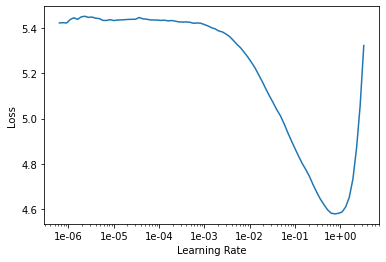

In [210]:
learn_fear_lm.recorder.plot()

In [211]:
learn_fear_lm.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.630728,3.702703,0.277083,00:01


In [0]:
learn_fear_lm.unfreeze()

In [213]:
learn_fear_lm.fit_one_cycle(10, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.104350,4.173859,0.177679,00:01
1,3.940274,3.995621,0.269643,00:01
2,3.868164,3.662478,0.268750,00:01
3,3.731884,3.550785,0.288988,00:01
4,3.602389,3.567528,0.285119,00:01
5,3.474763,3.539957,0.300893,00:01
6,3.317446,3.451663,0.328571,00:01
7,3.104427,3.367366,0.353869,00:01
8,2.849334,3.379138,0.378869,00:01
9,2.611831,3.350020,0.385119,00:01


In [0]:
learn_fear_lm.save('fine_tuned_fear')

In [0]:
learn_fear_lm.save_encoder('fine_tuned_fear_enc')

In [216]:
fear_regr = (TextList.from_df(df=fear_df, path=DATA_PATH, cols='text', vocab=data_fear_lm.vocab)
             .split_from_df(col='is_valid')
             .label_from_df(cols=['intensity'], label_cls=FloatList)
             .databunch())

In [217]:
fear_regr.show_batch()

text,target
xxbos xxmaj he : u r xxunk \n xxmaj she : i xxunk a xxunk \n \n xxmaj same as \n \n # xxmaj india : u guys r # terrorist \n # xxmaj pak : we have # xxunk # xxunk . \n \n # xxunk # terror,0.562
xxbos xxrep 5 xxunk \n / / xxmaj do n't worry if your xxunk is already taken . xxmaj the xxup xxunk i 'm looking for is a xxunk couple xxunk xxup xxunk . xxmaj just a fun xxunk xxunk . / / \n xxunk,0.188
"xxbos # xxup xxunk ? ? ? xxmaj when you turn on the xxup tv , etc . & & listen & & watch , the xxunk is to # xxunk with # fear & & # depression . # xxunk ! ! !",0.542
"xxbos xxmaj really xxrep 5 . # xxmaj xxunk 2 xxrep 4 . w / xxmaj the xxmaj xxunk , xxmaj jack xxmaj black , and xxmaj xxunk xxmaj xxunk ... are you kidding me ! xxup wtf ! # xxunk # horrible",0.542
"xxbos # xxunk xxup okay ! xxmaj that xxunk - scared the # xxmaj poop out of me right there . xxmaj bad dog , xxup bad ! xxmaj total xxunk - brown in my favorite pants . # xxmaj xxunk # horror",0.833


In [0]:
learn_fear = text_classifier_learner(fear_regr, AWD_LSTM, drop_mult=0.3,metrics = rmse)
learn_fear.loss_func=MSELossFlat()
learn_fear.load_encoder('fine_tuned_fear_enc')
learn_fear.freeze()

In [219]:
learn_fear.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


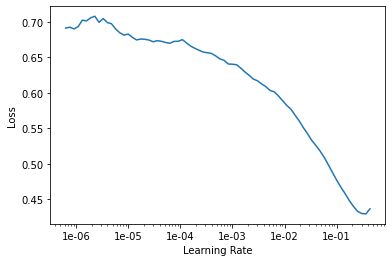

In [220]:
learn_fear.recorder.plot()

In [0]:
lr = 3e-2

In [222]:
learn_fear.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.354655,0.115537,0.339783,00:01


In [223]:
learn_fear.freeze_to(-2)
learn_fear.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.083723,0.033746,0.183007,00:01


In [224]:
learn_fear.freeze_to(-3)
learn_fear.fit_one_cycle(1, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.037477,0.040133,0.199662,00:01


In [225]:
learn_fear.unfreeze()
learn_fear.fit_one_cycle(5, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.029604,0.031708,0.177555,00:01
1,0.026270,0.029526,0.171180,00:01
2,0.024326,0.031416,0.176847,00:01
3,0.022753,0.029824,0.172246,00:01
4,0.021171,0.030209,0.173382,00:01


In [0]:
learn_fear.save('fear_regr')

### Joy - Regression

In [0]:
joy_df = pd.read_csv(DATA_PATH/"joy_df.csv")

In [228]:
data_joy_lm = (TextList.from_df(joy_df, DATA_PATH, cols=["text"])
                  .random_split_by_pct(0.1)
                  .label_for_lm()
                  .databunch(bs=48))

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:215: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [229]:
data_joy_lm.show_batch()

idx,text
0,"my day more joyful ! i love you too ! 😊 xxunk xxbos i feel so blessed to work with the family that i xxunk for ❤ ️ nothing but love & & xxunk , makes me smile . xxbos xxmaj today i xxunk xxunk xxunk on xxup xxunk ! ! , # xxunk , # xxunk xxbos xxunk xxmaj good morning , love ! xxmaj happy first day of"
1,"love xxunk xxunk ! xxmaj well done . xxmaj vote for # xxmaj trump . # lol # hilarious xxbos xxmaj when you wake up from a dream laughing at something stupid , and that makes you laugh more # hilarious xxbos now that i have my future xxunk out , i feel so much happier # goals # life # happy # xxunk # xxunk xxbos xxmaj online now"
2,"making me smile xxunk xxbos xxmaj today i xxunk xxunk xxunk on xxup xxunk ! ! # happy , # xxunk , # xxunk xxbos xxunk xxunk had more fun than the xxunk xxunk in xxunk xxrep 5 . xxmaj much hilarity as xxunk xxrep 4 . xxmaj thank you ❤ ️ xxbos xxunk xxunk xxup xxunk you 2 are xxunk me up ! xxmaj thanks for the follow xxmaj"
3,laughter xxbos xxunk _ xxunk you 're xxunk ! ! ! xxmaj but thank you a joyous evening xxunk xxbos i am so happy i have come across xxunk xxunk ! # xxunk would love to talk to you ! # xxunk # want # need # happy # amazing xxunk xxunk xxbos second day on the job and i already got a xxunk xxunk tip from a xxunk whose
4,"xxunk xxunk 😂 😂 😂 xxbos xxmaj happy xxmaj birthday xxunk # xxunk # xxunk # xxunk # xxunk # xxunk # xxmaj cheer xxbos thenicebot : xxunk xxunk xxmaj here is a smile and a xxunk from across the xxunk . # thenicebot xxbos a # smile xxunk your day and the day of everyone around you , so remember to # smile , it 's # free ."


In [0]:
learn_joy_lm = language_model_learner(data_joy_lm, AWD_LSTM, drop_mult=0.3)

In [231]:
learn_joy_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


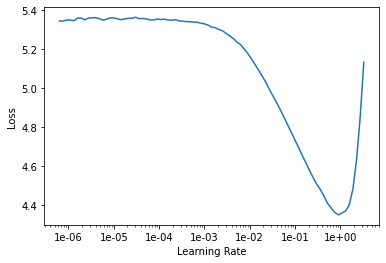

In [233]:
learn_joy_lm.recorder.plot()

In [238]:
learn_joy_lm.fit_one_cycle(1, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.673812,3.926357,0.281845,00:01


In [0]:
learn_joy_lm.unfreeze()

In [240]:
learn_joy_lm.fit_one_cycle(4, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.960380,5.105381,0.146131,00:01
1,3.938491,3.320180,0.334821,00:01
2,3.524615,3.076212,0.357143,00:01
3,3.134311,3.047039,0.369643,00:01


In [0]:
learn_joy_lm.save("fine_tuned_joy")

In [0]:
learn_joy_lm.save_encoder("fine_tuned_joy_enc")

In [243]:
joy_regr = (TextList.from_df(df=joy_df, path=DATA_PATH, cols='text', vocab=data_joy_lm.vocab)
             .split_from_df(col='is_valid')
             .label_from_df(cols=['intensity'], label_cls=FloatList)
             .databunch())

In [244]:
joy_regr.show_batch()

text,target
xxbos [ xxmaj moment of levity on the xxup xxunk ] xxmaj baby : i want xxup isis ! xxmaj give me xxup isis ! \n xxmaj mom : xxmaj xxunk ! \n xxmaj baby : i want xxup isis ! \n xxmaj xxunk xxmaj xxunk woman : xxmaj she xxunk what ? \n xxmaj mom : * xxmaj xxunk * .,0.521
xxbos xxmaj omg . xxmaj you 've got to watch the new series ' xxmaj this is xxmaj us ' xxrep 5 . wow . xxmaj best tv show i 've seen in a long time . \n # tears # laughter # xxunk,0.827
xxbos xxunk xxup xxunk xxmaj why would xxmaj xxunk xxunk & & xxmaj mom 's xxunk for a xxunk if it did not work ? xxmaj anyone listen to the xxmaj xxunk xxup xxunk 's xxunk xxmaj xxunk .. all were elated .,0.22
xxbos xxmaj omg . xxmaj you 've got to watch the new series ' xxmaj this is xxmaj us ' xxrep 5 . wow . xxmaj best tv show i 've seen in a long time . \n # tears # xxunk,0.5
"xxbos xxmaj be happy . xxmaj be who you want to be . xxmaj if xxunk do n't like it , then let them be . xxmaj happiness is a xxunk . xxmaj life is n't about pleasing xxunk xxrep 4 .",0.52


In [0]:
learn_joy = text_classifier_learner(joy_regr, AWD_LSTM, drop_mult=0.3,metrics = rmse)
learn_joy.loss_func=MSELossFlat()
learn_joy.load_encoder('fine_tuned_joy_enc')
learn_joy.freeze()

In [246]:
learn_joy.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


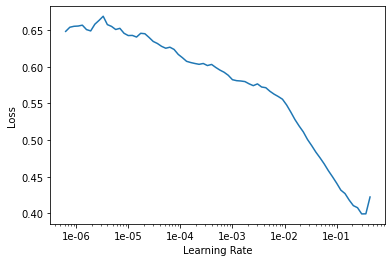

In [247]:
learn_joy.recorder.plot()

In [0]:
lr = 3e-2

In [249]:
learn_joy.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.531720,0.156700,0.391163,00:01


In [250]:
learn_joy.freeze_to(-2)
learn_joy.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.102279,0.043798,0.208840,00:01


In [251]:
learn_joy.freeze_to(-3)
learn_joy.fit_one_cycle(1, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.052437,0.035468,0.187768,00:01


In [252]:
learn_joy.unfreeze()
learn_joy.fit_one_cycle(5, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.029467,0.031102,0.175845,00:01
1,0.027189,0.030418,0.173744,00:01
2,0.023455,0.027855,0.166176,00:01
3,0.021097,0.027452,0.164827,00:01
4,0.018984,0.028023,0.166536,00:01


In [0]:
learn_joy.save("joy_regr")

### Sadness - Regression

In [0]:
sad_df = pd.read_csv(DATA_PATH/"sadness_df.csv")

In [255]:
data_sad_lm = (TextList.from_df(sad_df, DATA_PATH, cols=["text"])
                  .random_split_by_pct(0.1)
                  .label_for_lm()
                  .databunch(bs=48))

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:215: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [256]:
data_sad_lm.show_batch()

idx,text
0,me to hard rn xxbos xxmaj so when i try i fail ... and when i do n't try ... i still fail ... # confused and # lost xxbos xxmaj xxunk sadness xxbos my life in one word is depressing xxbos xxmaj xxunk xxunk are the worst . xxmaj feeling really sick and still xxunk . i should be a sleep . # anxiety # depression xxbos xxmaj feel
1,depression xxbos xxmaj the moment of the day when you have to start to xxunk a smile in your face . # depression xxbos i hate when it 's gloomy outside because it always gets me in a depressing mood xxbos xxmaj people xxunk things from my work out quite the damper on my day so now i am going to xxunk xxunk all day xxbos xxunk xxunk xxunk !
2,"xxunk \n road , \n still xxunk ! # depression \n \n # xxunk # xxunk xxbos xxmaj well my xxunk came back and i am xxunk xxunk . xxmaj xxunk xxunk xxunk on the xxup xxunk sunk my xxunk . it 's time for me to quit xxunk xxbos bad news xxunk , life is still hard and xxunk # depression # anxiety # xxunk xxbos"
3,"xxunk though lately with how bad my depression has been i feel like my body is like just , taking what little it can get xxbos xxmaj we have left # xxmaj xxunk . # sadness xxbos so fucking sad when the person you love does n't try fighting for your happiness , when you 'd do anything for them . xxbos xxunk # xxunk do u # wait 4"
4,xxmaj to good xxunk i lost my job i 'm xxmaj responsible 2 xxunk xxmaj my xxmaj xxunk in xxunk even xxunk if ca n’t just xxmaj re - tweet xxbos xxmaj xxunk xxunk anything xxunk to xxunk or xxmaj xxunk ! # xxunk # depressing # xxunk 😭 xxunk xxbos xxmaj it 's just xxunk xxunk and xxunk . xxmaj the war on xxunk has xxunk . # sadness


In [0]:
learn_sad_lm = language_model_learner(data_sad_lm, AWD_LSTM, drop_mult=0.3)

In [259]:
learn_sad_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


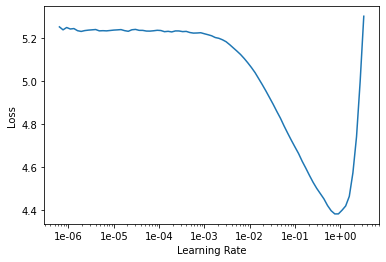

In [260]:
learn_sad_lm.recorder.plot()

In [265]:
learn_sad_lm.fit_one_cycle(1, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.663994,3.909419,0.283036,00:01


In [0]:
learn_sad_lm.unfreeze()

In [267]:
learn_sad_lm.fit_one_cycle(4, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.132400,4.325091,0.249702,00:01
1,4.091601,3.759883,0.287798,00:01
2,3.721377,3.632043,0.285417,00:01
3,3.357991,3.696711,0.292560,00:01


In [0]:
learn_sad_lm.save("fine_tuned_sad")

In [0]:
learn_sad_lm.save_encoder("fine_tuned_sad_enc")

In [271]:
sad_regr = (TextList.from_df(df=sad_df, path=DATA_PATH, cols='text', vocab=data_sad_lm.vocab)
             .split_from_df(col='is_valid')
             .label_from_df(cols=['intensity'], label_cls=FloatList)
             .databunch())

In [272]:
sad_regr.show_batch()

text,target
"xxbos xxmaj stars , when you xxunk , \n xxmaj you know how i feel . \n xxmaj xxunk of the pine , \n xxmaj you know how i feel . \n xxmaj xxunk is xxunk , \n i know how i feel . \n i 'm xxunk ' good .",0.292
xxbos xxmaj folk xxmaj band ' xxmaj xxunk xxmaj down ' will be replaced by ' xxmaj the xxmaj paul xxmaj xxunk xxmaj xxunk ' at xxmaj xxunk xxmaj bank xxmaj park xxmaj sat xxunk 11 am - 3 pm due to ill health # jazz # blues,0.417
"xxbos xxunk xxmaj start w / the 3 xxunk in xxmaj xxunk xxmaj xxunk \n 1 ) xxmaj wild \n xxunk \n xxunk xxmaj me down 😭 😭 for # xxmaj xxunk \n xxmaj also , \n xxunk xxmaj good . # serious xxunk / xxunk xxunk",0.375
xxbos xxmaj folk xxmaj band ' xxmaj xxunk xxmaj down ' will be replaced by ' xxmaj the xxmaj paul xxmaj xxunk xxmaj xxunk ' at xxmaj xxunk xxmaj bank xxmaj park xxmaj sat xxunk 11 am - 3 pm due to ill health # jazz,0.271
"xxbos xxup tonight - xxmaj xxunk xxmaj arms , xxmaj xxunk \n xxup tomorrow - xxmaj bank xxmaj top xxmaj xxunk , xxmaj xxunk \n xxup next xxup xxunk xxmaj big xxmaj hands , xxmaj xxunk \n \n # xxunk # xxunk # blues # xxunk",0.188


In [0]:
learn_sad = text_classifier_learner(sad_regr, AWD_LSTM, drop_mult=0.3,metrics = rmse)
learn_sad.loss_func=MSELossFlat()
learn_sad.load_encoder('fine_tuned_sad_enc')
learn_sad.freeze()

In [274]:
learn_sad.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


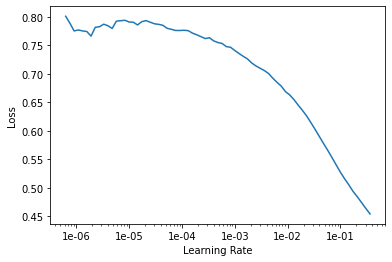

In [275]:
learn_sad.recorder.plot()

In [0]:
lr = 1e-2

In [283]:
learn_sad.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.461796,0.163106,0.403289,00:01


In [284]:
learn_sad.freeze_to(-2)
learn_sad.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.200374,0.103086,0.320573,00:01


In [285]:
learn_sad.freeze_to(-3)
learn_sad.fit_one_cycle(1, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.120822,0.064729,0.253359,00:01


In [286]:
learn_sad.unfreeze()
learn_sad.fit_one_cycle(5, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.085414,0.060042,0.244082,00:01
1,0.078301,0.049850,0.222402,00:01
2,0.065446,0.044837,0.211087,00:01
3,0.057842,0.045593,0.212783,00:01
4,0.053062,0.045571,0.212668,00:01


In [0]:
learn_sad.save("sad_regr")

In [0]:
anger_regr.save("textlist_anger_regr")
fear_regr.save("textlist_fear_regr")
joy_regr.save("textlist_joy_regr")
sad_regr.save("textlist_sad_regr")

### Combining Classifier and Intensity Predictor

In [0]:
tweet = "Hey! I like to enjoy the sun in mornings.#veryhappy"

In [0]:
pred = predict_emotion(tweet)[0][1].item()

In [0]:
all_data = ['textlist_anger_regr','textlist_fear_regr','textlist_joy_regr','textlist_sad_regr']
all_regr = ['anger_regr','fear_regr','joy_regr','sad_regr']

In [0]:
data = load_data(DATA_PATH, all_data[pred], bs=48, num_workers=1)
learn = text_classifier_learner(data, AWD_LSTM, drop_mult=0.5, metrics=rmse)
learn.load(all_regr[pred], purge=False);

In [313]:
pred, learn.predict(tweet)

(2, (FloatItem [0.583689], tensor([0.5837]), tensor([0.5837])))

In [0]:
def find_intensity(text):
  emotion = predict_emotion(text)[0]
  idx = emotion[1].item()

  all_data = ['textlist_anger_regr','textlist_fear_regr','textlist_joy_regr','textlist_sad_regr']
  all_regr = ['anger_regr','fear_regr','joy_regr','sad_regr']

  data = load_data(DATA_PATH, all_data[idx], bs=48, num_workers=1)
  learn = text_classifier_learner(data, AWD_LSTM, drop_mult=0.5, metrics=rmse)
  learn.load(all_regr[idx], purge=False);
  intensity = learn.predict(text)

  return emotion[0], intensity[0]

In [327]:
find_intensity("I feel like crying")

(Category sadness, FloatItem [0.663947])

In [330]:
find_intensity("Fuck you!")

(Category anger, FloatItem [0.442915])

In [337]:
find_intensity("I'm scared to say it")

(Category fear, FloatItem [0.379185])